In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Loaded checkpoint from epoch 28
Epoch [30/30], Loss: 0.0451, Train Acc: 98.52%, Val Acc: 80.10%
Model saved as 'trained_skin_cancer_model.pkl'
Training completed!
Test Accuracy: 80.00%
Confusion Matrix:
[[ 16  15   0   1  12   0   0]
 [  3 209   0   0   3   1   0]
 [  0   1  10   1   2   1   1]
 [  0   2   1   4   3   0   0]
 [  1   8   1   2  20   0   0]
 [  0   4   1   0   0   1   0]
 [  0   1   1   0   0   0   4]]


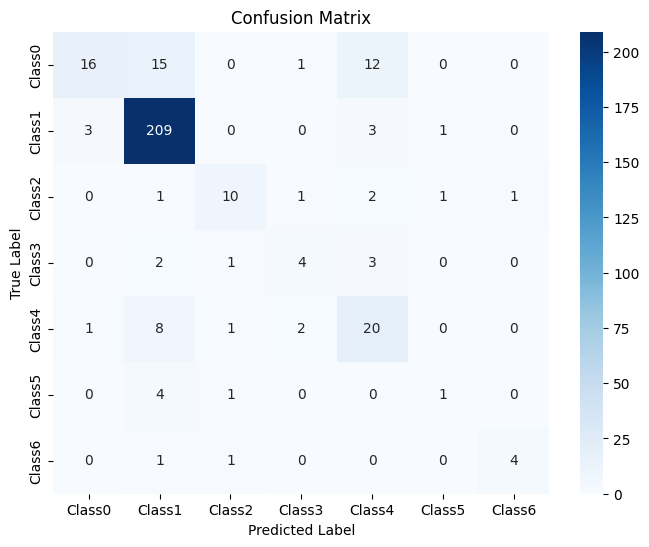

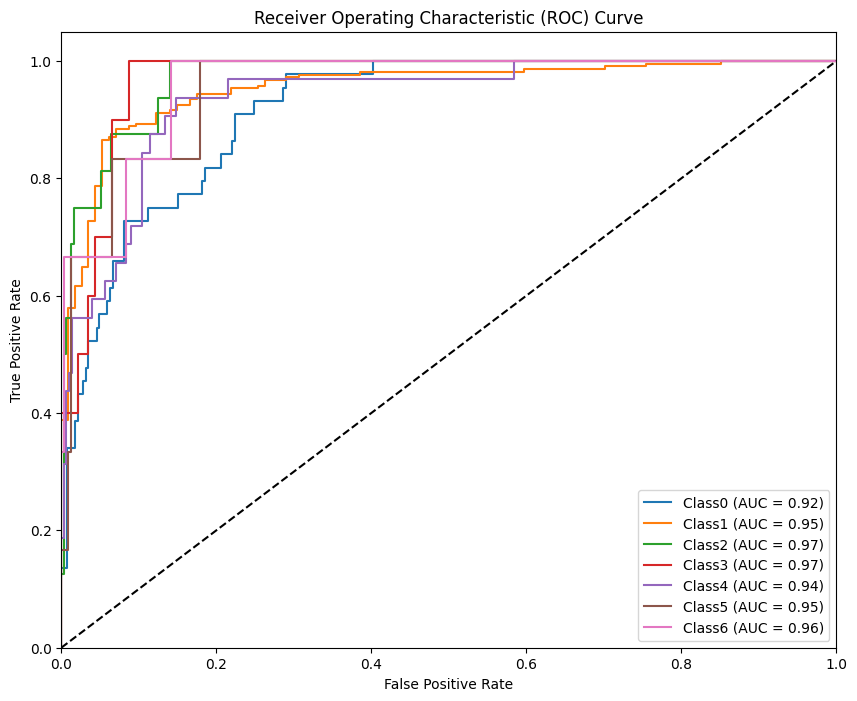

Precision: 0.7955
Recall: 0.8000
F1 Score: 0.7836


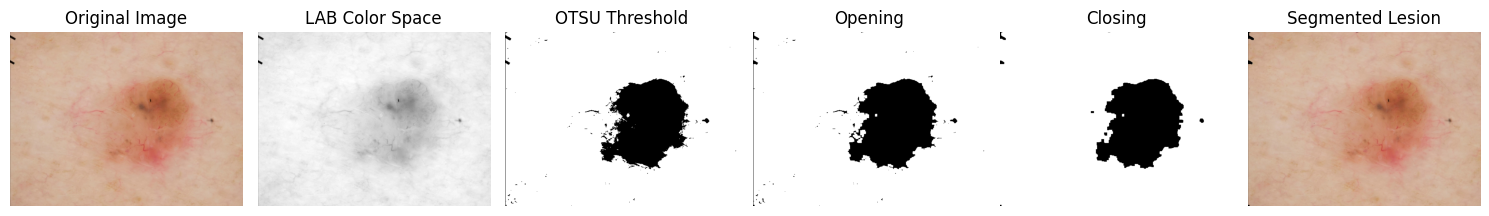

Predicted Class: 2, Confidence: 0.8513131141662598


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torchvision import transforms, datasets, models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import pickle

class SkinLesionSegmentation:
    def __init__(self):
        self.kernel = np.ones((5,5), np.uint8)

    def segment_lesion(self, image):
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        # Apply OTSU thresholding on L channel
        _, thresh = cv2.threshold(lab[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphological operations
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, self.kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, self.kernel)

        # Find the largest contour (assumed to be the lesion)
        contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return image

        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(thresh)
        cv2.drawContours(mask, [largest_contour], -1, (255,255,255), -1)

        # Apply mask to original image
        segmented = cv2.bitwise_and(image, image, mask=mask)
        return segmented

def visualize_segmentation(image_path):
    """
    Visualize the steps of skin lesion segmentation
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a segmentation object
    segmenter = SkinLesionSegmentation()

    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Apply OTSU thresholding on L channel
    _, thresh = cv2.threshold(lab[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, segmenter.kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, segmenter.kernel)

    # Find contours
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Create mask
    mask = np.zeros_like(thresh)
    cv2.drawContours(mask, [largest_contour], -1, (255,255,255), -1)

    # Apply mask
    segmented = cv2.bitwise_and(image, image, mask=mask)

    # Visualization
    plt.figure(figsize=(15,3))

    plt.subplot(161)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(162)
    plt.title('LAB Color Space')
    plt.imshow(lab[:,:,0], cmap='gray')
    plt.axis('off')

    plt.subplot(163)
    plt.title('OTSU Threshold')
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')

    plt.subplot(164)
    plt.title('Opening')
    plt.imshow(opening, cmap='gray')
    plt.axis('off')

    plt.subplot(165)
    plt.title('Closing')
    plt.imshow(closing, cmap='gray')
    plt.axis('off')

    plt.subplot(166)
    plt.title('Segmented Lesion')
    plt.imshow(segmented)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

class FeatureExtractor:
    def __init__(self):
        self.scaler = StandardScaler()

    def extract_features(self, image):
        # Convert to grayscale for texture features
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Extract GLCM features
        glcm = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
        contrast = feature.graycoprops(glcm, 'contrast').ravel()
        dissimilarity = feature.graycoprops(glcm, 'dissimilarity').ravel()
        homogeneity = feature.graycoprops(glcm, 'homogeneity').ravel()
        energy = feature.graycoprops(glcm, 'energy').ravel()
        correlation = feature.graycoprops(glcm, 'correlation').ravel()

        # Color features
        color_features = []
        for channel in cv2.split(image):
            color_features.extend([np.mean(channel), np.std(channel)])

        # Combine all features
        features = np.concatenate([contrast, dissimilarity, homogeneity,
                                 energy, correlation, color_features])
        return features

# Checkpoint directory setup
CHECKPOINT_DIR = '/content/drive/MyDrive/skin_cancer_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, best_val_acc):
    """
    Save model checkpoint with training state
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc
    }
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch}')

def load_checkpoint(model, optimizer):
    """
    Load the latest checkpoint if available
    """
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('checkpoint_')]

    if not checkpoints:
        print('No checkpoints found. Starting training from scratch.')
        return 0, 0.0

    # Sort checkpoints to get the latest one
    latest_checkpoint = sorted(checkpoints)[-1]
    checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']

    print(f'Loaded checkpoint from epoch {start_epoch-1}')
    return start_epoch, best_val_acc

# Custom Dataset class for skin lesion images
class SkinLesionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.segmenter = SkinLesionSegmentation()
        self.feature_extractor = FeatureExtractor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)

        # Segment the lesion
        segmented = self.segmenter.segment_lesion(img)

        # Extract features (for potential use in ensemble methods)
        features = self.feature_extractor.extract_features(segmented)

        # Transform the segmented image for CNN
        if self.transform:
            segmented = self.transform(segmented)

        return segmented, torch.tensor(features, dtype=torch.float32), label

# Data augmentation and transformation
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Paths for dataset
train_dir = '/content/drive/MyDrive/ISIC_DIP/organized_Train'
test_dir = '/content/drive/MyDrive/ISIC_DIP/organized_Test'
val_dir = '/content/drive/MyDrive/ISIC_DIP/organized_Val'

# Create datasets
train_dataset = SkinLesionDataset(train_dir, transform=data_transform)
test_dataset = SkinLesionDataset(test_dir, transform=data_transform)
val_dataset = SkinLesionDataset(val_dir, transform=data_transform)

# Create data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Modified ResNet model to incorporate extracted features
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Remove the last layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # Additional layers for feature fusion
        self.feature_fc = nn.Linear(26, 64)  # 26 is the number of extracted features
        self.fusion = nn.Linear(num_ftrs + 64, num_classes)

    def forward(self, x, features):
        x = self.resnet(x)
        features = self.feature_fc(features)
        combined = torch.cat((x, features), dim=1)
        return self.fusion(combined)

# Training function
def train_model():
    # Initialize model, criterion, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ModifiedResNet(num_classes=len(train_dataset.dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Load checkpoint or start from scratch
    start_epoch, best_val_acc = load_checkpoint(model, optimizer)

    # Training loop
    num_epochs = 30
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, features, labels in train_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, features, labels in val_loader:
                images, features, labels = images.to(device), features.to(device), labels.to(device)
                outputs = model(images, features)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Step the scheduler with validation loss
        scheduler.step(avg_val_loss)

        # Save checkpoint every 5 epochs and when validation accuracy improves
        if epoch % 5 == 0 or val_acc > best_val_acc:
            save_checkpoint(model, optimizer, epoch, val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_skin_cancer_model.pth')

    # Save the final trained model as .pkl
    with open('trained_skin_cancer_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("Model saved as 'trained_skin_cancer_model.pkl'")

    print("Training completed!")
    return model

# Test the model
def test_single_image(image_path, model, transform):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    segmenter = SkinLesionSegmentation()
    feature_extractor = FeatureExtractor()

    # Segment the lesion
    segmented = segmenter.segment_lesion(image)

    # Extract features
    features = feature_extractor.extract_features(segmented)
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)

    # Transform image for model
    segmented = transform(segmented).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(segmented, features)
        prob = torch.nn.functional.softmax(output, dim=1)
        pred_class = torch.argmax(prob, dim=1).item()
        confidence = prob[0][pred_class].item()

    return pred_class, confidence

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    all_probs = []

    with torch.no_grad():
        for images, features, labels in test_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            outputs = model(images, features)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.dataset.classes,
                yticklabels=test_loader.dataset.dataset.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC and AUC
    true_labels_bin = np.eye(len(test_loader.dataset.dataset.classes))[true_labels]  # One-hot encoding of true labels
    all_probs = np.array(all_probs)  # Convert list of probabilities to array

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(test_loader.dataset.dataset.classes):
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Optional: Calculate additional metrics
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return test_accuracy


# In the main execution block, add:
if __name__ == "__main__":
    # Train the model
    trained_model = train_model()

    # Test the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_model(trained_model, test_loader, device)

    # Optional: Test on a single image
    test_image_path = '/content/drive/MyDrive/ISIC_DIP/organized_Test/Class2/ISIC_0024452.jpg'
    visualize_segmentation(test_image_path)
    pred_class, confidence = test_single_image(test_image_path, trained_model, data_transform)
    print(f"Predicted Class: {pred_class}, Confidence: {confidence}")